In [3]:
import pandas as pd
import numpy as np

# Load Data
df = pd.read_csv('agg_data/conv_traf.csv')
df

C:\Users\edwin\AppData\Local\Temp\ipykernel_49784\1969230939.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('agg_data/conv_traf.csv')


,fullVisitorId,date,conversion,convSoFar,value,source,medium,channelGrouping,isTrueDirect,newVisitor,isNewVisit,isFirstConversion
0,1235242196175467,2016-11-01,0,0,NaN,baidu,organic,Organic Search,NaN,1.0,1.0,0
1,15980521034237800,2016-12-08,0,0,NaN,facebook.com,referral,Social,NaN,1.0,1.0,0
2,34572692224994048,2016-10-03,0,0,NaN,baidu,organic,Organic Search,NaN,1.0,1.0,0
3,40335064426021006,2016-08-31,0,0,NaN,phandroid.com,referral,Referral,NaN,1.0,1.0,0
4,47788902811115718,2016-12-14,0,0,NaN,adwords.google.com,referral,Referral,NaN,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
903648,9981048921160614325,2017-01-09,0,0,NaN,youtube.com,referral,Social,NaN,1.0,1.0,0
903649,9983899559058751167,2016-10-08,0,0,NaN,youtube.com,referral,Social,NaN,1.0,1.0,0
903650,9985652375912834608,2016-10-22,0,0,NaN,youtube.com,referral,Social,NaN,1.0,1.0,0
903651,998979252829558548,2017-04-27,0,0,NaN,youtube.com,referral,Social,NaN,1.0,1.0,0


In [4]:
# Fill na with 0
df = df.fillna(0)

In [5]:
# Redefine the medium column based on their definitions
map_dictionary = {'organic': 'Search', '(none)': 'Direct', 
                  'referral': 'Referral', 'cpc':'Paid Search', 
                  'affiliate': 'Affiliate', 'cpm': 'Display Ad', '(not set)': 'Direct'}

df['medium'] = df['medium'].map(map_dictionary)

df['medium'].value_counts()

medium
Direct         371584
Referral       262022
Search         234381
Affiliate       16403
Paid Search     13079
Display Ad       6184
Name: count, dtype: int64

# Medium Variance over Time

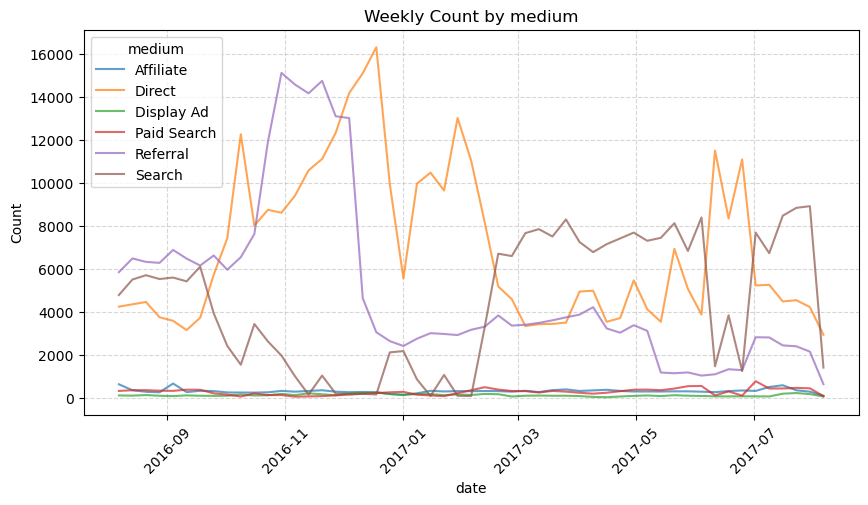

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Resample to weekly data
grouped_weekly = df.groupby([pd.Grouper(key='date', freq='W'), 'medium']).agg({'fullVisitorId': 'count', 'value' : 'sum', 'conversion' : 'sum'}).reset_index()


def weekly_plot_by_medium(data = grouped_weekly, by = 'medium', col= 'fullVisitorId', title = 'Count'):
    # Define the desired legend order
    if by == 'medium':
        medium_order = ["Affiliate", "Direct", "Display Ad", "Paid Search", "Referral", "Search"]
    else:
        medium_order = None
        
    # Create the line plot with the specified order
    plt.figure(figsize=(10, 5))  # Adjust figure size if needed
    sns.lineplot(
        data= data, 
        x='date', 
        y= col, 
        hue= by, 
        hue_order=medium_order,  # Ensures consistent legend order
        linewidth=1.5, 
        alpha=0.7
    )

    # Format x-axis ticks
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylabel(title)
    plt.title(f'Weekly {title} by {by}')

    # Add a grid for better visualization
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.show()

weekly_plot_by_medium(col = 'fullVisitorId')


Unable to investigate yearly pattern. However, weekly count of visits from direct and search seems to be negatively correlated. Referral's attraction drops across the year, potentially where visitors search the about the company which leads to the company website and saved the website for future visits, and so the search number decreases where the source users transferred to using the direct source. Conversely, around 2017-02, when direct uses dropped, the company may have increased advertisements (paid search, and display ads) or promotions and increased exposure of the company offline.

However, the visits from referral dropped overtime, likely due to the number of visitors the company's partners' and existing customers' referred is limited, and the speed of referral is much quicker than the increase in new connections from the partners and customers.

In [ ]:
from scipy.stats import pearsonr

statistics, pvalue = pearsonr(grouped_weekly.loc[grouped_weekly['medium'] == 'Direct', 'fullVisitorId'], grouped_weekly.loc[grouped_weekly['medium'] == 'Search', 'fullVisitorId'])
if pvalue <= 0.01:
    print(f"Pearson Correlation Test shows significant evident between weekly visits from 'Direct' and 'Search', with the Pearson Correlation Coefficient {statistics}.")

Pearson Correlation Test shows significant evident between weekly visits from 'Direct' and 'Search', with the Pearson Correlation Coefficient -0.84041435328884


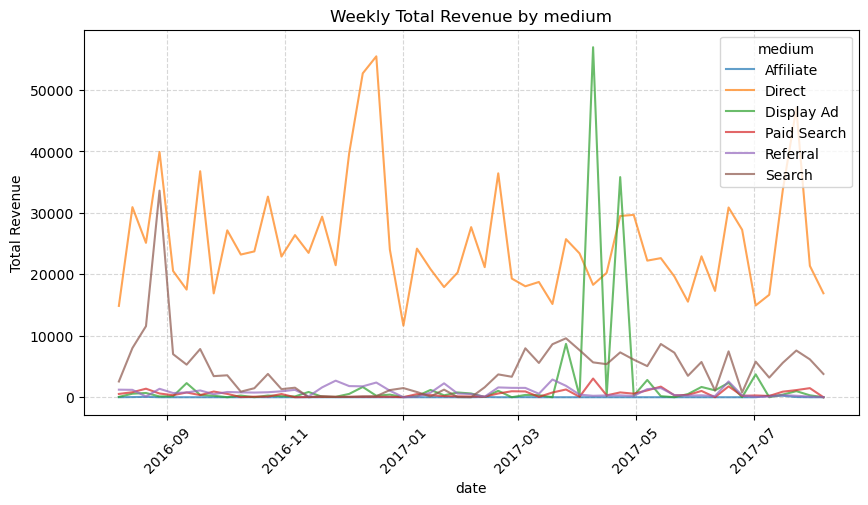

In [7]:
weekly_plot_by_medium(col = 'value', title = 'Total Revenue')

Only 'Direct' and 'Search' has the most consistent weekly revenue. In addition, there is a spike in revenue between 2017-MAR till 2017-MAY from display ad, potentially an anomaly or some event occured, but we are unable to track it.

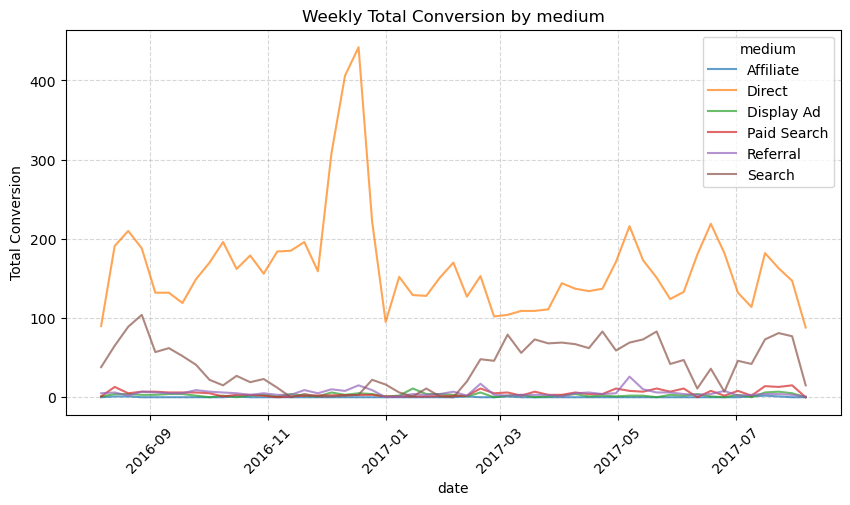

In [8]:
weekly_plot_by_medium(col = 'conversion', title = 'Total Conversion')

Consistent weekly total conversions for 'Direct', but it doesn't seem to correlate with the weekly visits. 'Search' has a drop in conversion from 2016-09 till 2017-02, and this correlated with the weekly visits from 'Search', and it increases onwards. 

# Specific Source Comparisons

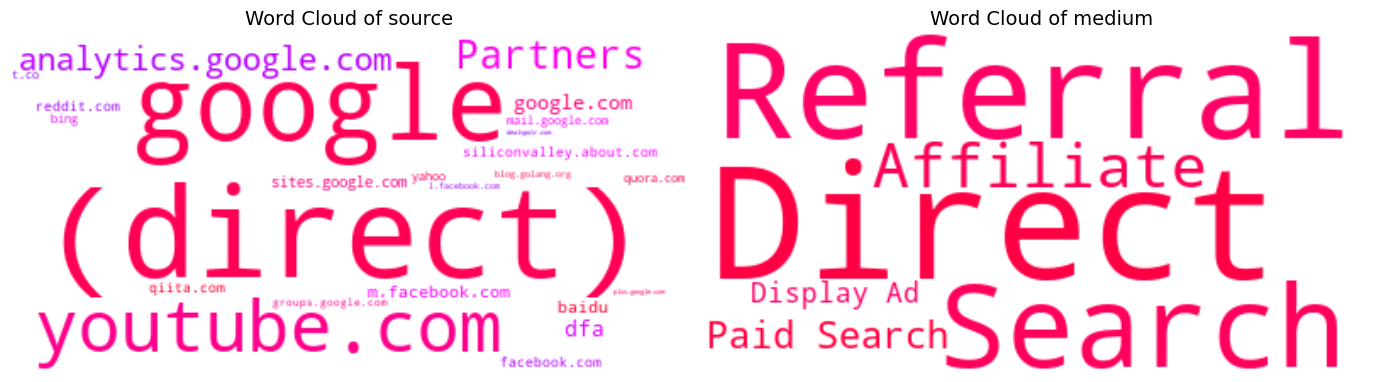

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random

# Rainbow Coloring Function
def rainbow_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    hue = random.randint(270, 350)  # Random hue for rainbow effect
    return f"hsl({hue}, 100%, 50%)"  # Full saturation and medium brightness for vibrant colors

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

for i, col in enumerate(['source', 'medium']):
    # Count unique words
    word_counts = Counter(df[col].tolist())

    # Generate WordCloud using frequency dictionary
    wordcloud = WordCloud(max_words=30, background_color="white").generate_from_frequencies(word_counts)

    # Plot in subplot
    axes[i].imshow(wordcloud.recolor(color_func=rainbow_color_func, random_state=3), interpolation='bilinear')
    axes[i].set_title(f'Word Cloud of {col}', fontsize=14)
    axes[i].axis("off")  # Hide axes

# Adjust layout
plt.tight_layout()
plt.show()

The word cloud for medium has referral as the main medium, but looking at the sources, Partners and dfa contribute much less than direct and google. This indicates that some customers might have click off the site and re-entered them directly after some time.

In [10]:
# Function to categorize sources based on link
def categorize_source(source):
    source = str(source).lower()  # Convert to lowercase for consistency
    
    if 'google' in source:
        return 'Google'
    elif 'youtube' in source:
        return 'YouTube'
    elif 'facebook' in source:
        return 'Facebook'
    elif 'reddit' in source:
        return 'Reddit'
    elif 'quora' in source:
        return 'Quora'
    elif 'dfa' in source:
        return 'dfa'
    elif 'Partners' in source:
        return 'Partners'
    else:
        return 'Other'  # Default category for unknown sources

# Apply categorization function to the 'source' column
df['source_category'] = df['source'].apply(categorize_source)

# Value count
df['source_category'].value_counts()

source_category
Other       404331
Google      270764
YouTube     212697
Facebook      6523
dfa           5686
Reddit        2106
Quora         1546
Name: count, dtype: int64

In [11]:
# Revenue proportion by sources category
(df.groupby('source_category')['value'].sum()/df['value'].sum()).sort_values( ascending = False)

source_category
Other       0.754945
Google      0.169356
dfa         0.072346
Facebook    0.003126
YouTube     0.000199
Quora       0.000018
Reddit      0.000010
Name: value, dtype: float64

In [30]:
# Summarize revenue and conversion by source categories
summary_df = df.groupby('source_category').agg(
                total_revenue = ('value', 'sum'),
                total_visits = ('fullVisitorId', 'count'),
                total_conversions = ('conversion', 'sum')
            )
summary_df['revenue per conversion'] = round(summary_df['total_revenue']/summary_df['total_conversions'],2)
summary_df['conversion rate'] = round(summary_df['total_conversions']/summary_df['total_visits'] *100, 2)
summary_df

,total_revenue,total_visits,total_conversions,revenue per conversion,conversion rate
source_category,,,,,
Facebook,5564.43,6523,39,142.68,0.60
Google,301479.64,270764,2503,120.45,0.92
Other,1343913.99,404331,8873,151.46,2.19
Quora,31.98,1546,1,31.98,0.06
Reddit,16.97,2106,1,16.97,0.05
YouTube,355.07,212697,11,32.28,0.01
dfa,128787.15,5686,124,1038.61,2.18


The table presents data on various source categories, showing that Google and Other drive a large number of visits but have relatively low revenue per conversion. Google, in particular, stands out with the highest visits, yet the revenue per conversion is much lower compared to other sources. This suggests that while these sources have the potential to attract a high volume of new visitors, they may not be as efficient at converting those visitors into high-value actions. However, their consistent traffic flow and relatively steady revenue streams make them valuable for maintaining a broad presence online, even if their individual conversion efficiency isn't as high.

In contrast, dfa exhibits a much higher revenue per conversion, indicating a more effective return on investment for every successful conversion. With a conversion rate similar to Other, it demonstrates solid potential for generating substantial revenue with fewer but higher-value conversions. 

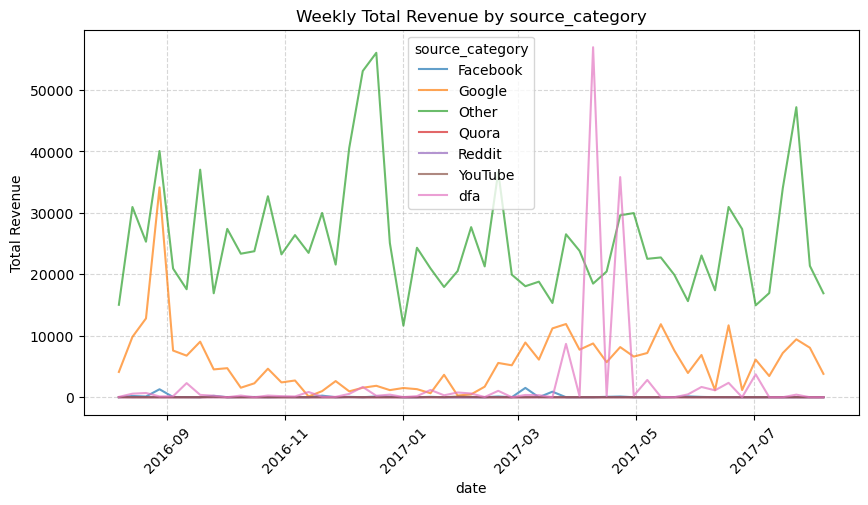

In [27]:
# Source Category Revenue
cat_weekly = df.groupby([pd.Grouper(key='date', freq='W'), 'source_category']).agg({'fullVisitorId' : 'count', 'value' : 'sum', 'conversion' : 'mean'}).reset_index()
cat_weekly['revenue per visit'] = cat_weekly['value']/cat_weekly['fullVisitorId']

# Plot
weekly_plot_by_medium(data = cat_weekly, by = 'source_category', col = 'value', title = 'Total Revenue')

Dfa contributes majority of display ad's revenue The cost of each source for advertisement or referral is unknown, hence the decision to relocate budget from low return per cost and return per impression. But we can assess revenue per visit and conversion rate.

Putting the graph with the previous weekly total revenue by medium side by side, there are the following correlations:

- Other -> Direct
- Google -> Both Search and Paid Search
- dfa -> Display Ads
- YouTube, Quora, Facebook, Reddit -> Affliate, Paid Search, Display Ads


The risk with dfa lies in its inconsistency; the revenue spike observed during a specific month suggests that the source generates revenue in bursts rather than continuously throughout the year. This pattern introduces volatility and makes dfa a more risky investment, as its performance can fluctuate significantly between periods.

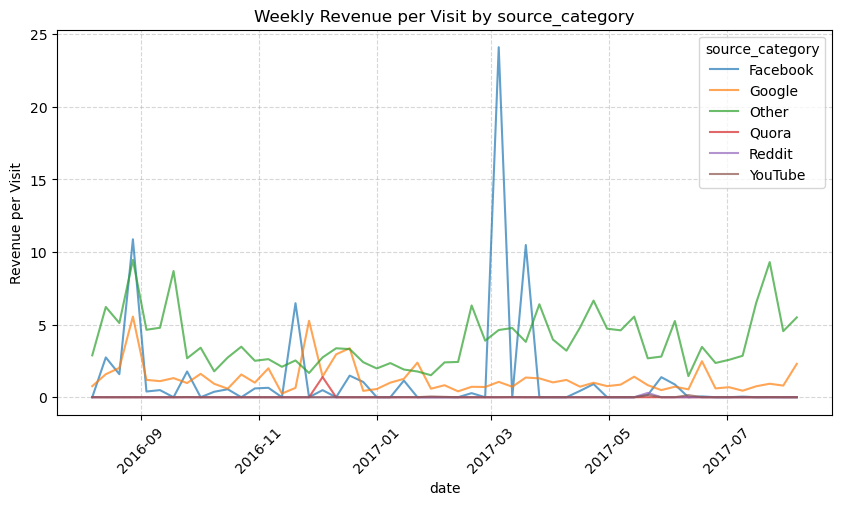

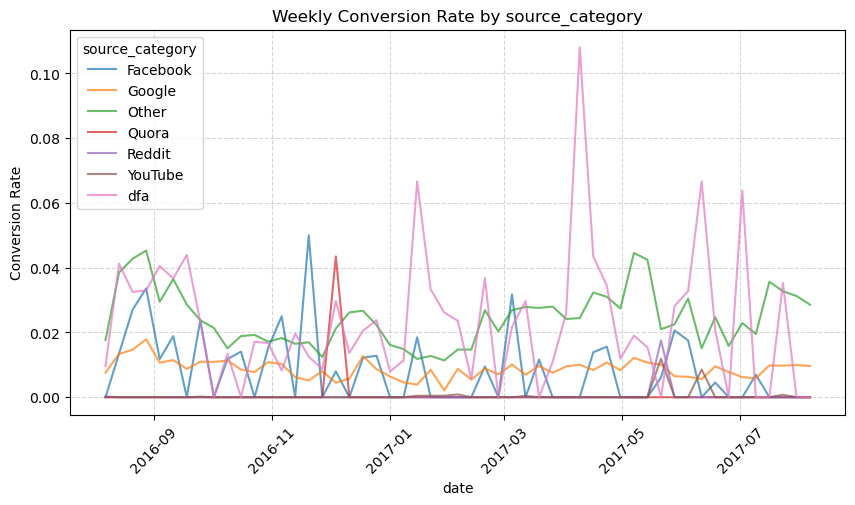

In [13]:
# Plot revenue per visit
weekly_plot_by_medium(data = cat_weekly[cat_weekly['source_category'] != 'dfa'], by = 'source_category', col = 'revenue per visit', title = 'Revenue per Visit')

# Plot conversion rate
weekly_plot_by_medium(data = cat_weekly, by = 'source_category', col = 'conversion', title = 'Conversion Rate')

# Conclusion

In conclusion, Google and Other are safer, more reliable choices for generating consistent traffic and revenue, while dfa presents a higher-risk, higher-reward opportunity that could substantially improve revenue but also requires close monitoring due to its volatility. The lack of seasonality analysis further complicates the decision-making process, and more data is needed to fully understand how these sources perform over different times of the year.

The absence of seasonality data in the current dataset limits our ability to fully assess the performance of these sources throughout the year. Seasonality could significantly impact revenue and conversion rates, and further data collection across multiple years would be crucial to validate any patterns related to time of year, holidays, or other external factors.